# Datagnosis Tutorial 01 - simple tabular example

*If you prefer, this tutorial is also available on [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1PPcjl9jq6E4j3Qz0cZIQbbQTaeK2qH6b/view?usp=sharing)

In this tutorial we will see how to use "hardness characterization method" plugins to calculate the hardness scores for the data points in a dataset. We will also plot these values and extract some data points based on these scores. For this tutorial we will be using the iris dataset from scikit learn. For a more realistic dataset checkout tutorials 2 and 3!

OK, Lets start!

First we import our logger from datagnosis and set the logging level at "INFO". If something goes wrong and you want to see more detailed logs, you can change the logging level to "DEBUG" or, conversely, if you don't want to see any logs you can remove them with log.remove().

In [1]:
import sys
import datagnosis.logger as log
log.add(sink=sys.stderr, level="INFO")

Load the dataset

In [2]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True, as_frame=True)
df = X.copy(deep=True)
df['target'] = y
display(df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Do some pre-processing on the data if you like, such as scaling. 

The next key step is to then pass the data to the DataHandler object provided by Datagnosis. This is done by passing the features and the labels separately. The features can be a `pandas.DataFrame`, `numpy.ndarray` or `torch.Tensor`. The labels can be `pandas.series`, `numpy.ndarray` or `torch.Tensor`.

In [3]:

from datagnosis.plugins.core.datahandler import DataHandler
from datagnosis.plugins.core.models.simple_mlp import SimpleMLP
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

std_scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

datahander = DataHandler(X_train, y_train, batch_size=32)

Now we define some values which we will pass to the plugin, such as the model that we want to use to classify the data.

In [4]:

# creating our model object, which we both want to use downstream, but also we will use to judge the hardness of the data points
model = SimpleMLP()

# creating our optimizer and loss function objects
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

Import the `Plugins` object from Datagnosis. Then by calling `list()` on the we can see all the available plugins that we can use.

In [5]:
# datagnosis absolute
from datagnosis.plugins import Plugins

plugins = Plugins().list()
print(plugins)


['vog', 'large_loss', 'grand', 'conf_agree', 'prototypicality', 'aum', 'el2n', 'confident_learning', 'data_maps', 'allsh', 'data_iq', 'forgetting']


Now we can call `get()` to load up a specific plugin from the list.

In [6]:
hcm = Plugins().get(
    "data_iq",
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    lr=learning_rate,
    epochs=10,
    num_classes=3,
    logging_interval=1,
)


Next we need to `fit()` the plugin

In [7]:

hcm.fit(
    datahandler=datahander,
    use_caches_if_exist=True,
)

[2023-08-02T15:01:14.753523+0100][53711][INFO] Fitting data_iq plugin
[2023-08-02T15:01:19.553865+0100][53711][INFO] Epoch 1/10: Loss=0.6950
[2023-08-02T15:01:19.621102+0100][53711][INFO] Epoch 2/10: Loss=0.2694
[2023-08-02T15:01:19.679058+0100][53711][INFO] Epoch 3/10: Loss=0.1799
[2023-08-02T15:01:19.718588+0100][53711][INFO] Epoch 4/10: Loss=0.0955
[2023-08-02T15:01:19.758410+0100][53711][INFO] Epoch 5/10: Loss=0.0779
[2023-08-02T15:01:19.798361+0100][53711][INFO] Epoch 6/10: Loss=0.1023
[2023-08-02T15:01:19.838366+0100][53711][INFO] Epoch 7/10: Loss=0.0663
[2023-08-02T15:01:19.877606+0100][53711][INFO] Epoch 8/10: Loss=0.0481
[2023-08-02T15:01:19.916285+0100][53711][INFO] Epoch 9/10: Loss=0.0544
[2023-08-02T15:01:19.955706+0100][53711][INFO] Epoch 10/10: Loss=0.0513


Now the plugin has been fit we can access scores. First, lets get a description of the scores then print them.

In [15]:
print(hcm.score_description())
print(hcm.scores)


<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Printing the scores leaves them difficult to digest, so now we will plot them instead. We can plot 1-dimentional scores in two different ways with `plot_type="dist"` or `plot_type="scatter"`. Why not have a look at both types and compare?

[2023-08-02T15:01:20.028794+0100][53711][INFO] Plotting data_iq scores


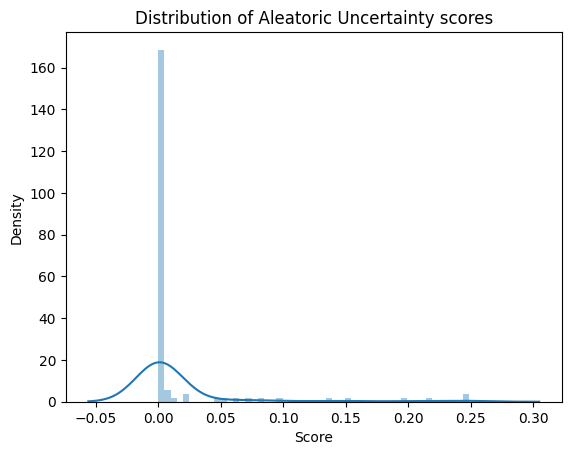

In [9]:

hcm.plot_scores(axis=1, plot_type="dist")

Finally the `extract_datapoints` method can be used to select data based on the hcm score. Available methods for extract include `"top_n"`, `"threshold"` and `"index"`. Give them all a go!

The following cell takes the hardest 10 data points summarises them in a `pandas.DataFrame`.

In [16]:
import pandas as pd
print(f"Data points that are hard to classify have scores that are: {hcm.hard_direction()}")
hardest_10 = hcm.extract_datapoints(method="index", indices=[1,2,6,10])

display(pd.DataFrame(
    data={
        "indices":hardest_10[0][2],
        f"{X.columns[0]}": hardest_10[0][0].transpose(0,1)[0],
        f"{X.columns[1]}": hardest_10[0][0].transpose(0,1)[1],
        f"{X.columns[2]}": hardest_10[0][0].transpose(0,1)[2],
        f"{X.columns[3]}": hardest_10[0][0].transpose(0,1)[3],
        "labels": hardest_10[0][1],
        "scores": hardest_10[1],
    }
))

Data points that are hard to classify have scores that are: low


,indices,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),labels,scores
0,1,-0.099845,-1.040395,0.113560,-0.029841,1,0.991709
1,2,1.053005,-0.119255,0.950314,1.127075,2,1.000000
2,6,-0.560985,1.492741,-1.281031,-1.315303,0,1.000000
3,10,0.130725,-1.961535,0.671396,0.355798,2,1.000000


In [11]:
print(hardest_10)

((tensor([[-1.0221e+00, -2.4221e+00, -1.6536e-01, -2.8693e-01],
        [-4.4570e-01, -1.5010e+00,  1.9923e-03, -1.5839e-01],
        [-6.7627e-01,  1.4927e+00, -1.2810e+00, -1.3153e+00],
        [ 5.9186e-01, -8.1011e-01,  8.3875e-01,  8.6998e-01],
        [-9.0684e-01,  1.7230e+00, -1.2252e+00, -1.3153e+00],
        [-7.9155e-01,  8.0189e-01, -1.3368e+00, -1.3153e+00],
        [ 2.0906e+00, -1.0404e+00,  1.7313e+00,  1.3842e+00],
        [-1.3680e+00,  3.4132e-01, -1.2252e+00, -1.3153e+00],
        [-2.1513e-01, -1.0404e+00, -1.6536e-01, -2.8693e-01],
        [ 4.7658e-01, -3.4954e-01,  1.0061e+00,  7.4144e-01]]), tensor([1, 1, 0, 2, 0, 0, 2, 0, 1, 2]), [7, 15, 30, 32, 49, 69, 76, 85, 91, 108]), array([0.9221698 , 0.46798903, 0.73497045, 0.88869566, 0.31462792,
       0.93475664, 0.8169474 , 0.90839595, 0.44496712, 0.83549249]))
